In [1]:
# Date: 22-5-2017

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import datetime

Using TensorFlow backend.


In [2]:
# Note: caution: 十一黃金周

df_merged_volume = pd.read_csv("../data/preprocessed_input_interpolate_20min_phase1and2_train.csv")

# change "Date" to datetime object
df_merged_volume['date'] = pd.to_datetime(df_merged_volume['date'])

# construct "time of day"
df_merged_volume['timeofday'] = df_merged_volume.date.apply( lambda d : d.hour+d.minute/60.)

In [3]:
# Select the phase 1 day

# end_day = datetime.datetime(year=2016, month=10, day=18, hour=0, minute=0, second=0)

# df_merged_volume = df_merged_volume[(df_merged_volume['date'] < end_day)]

In [4]:
# check any unreasonable rows
df_merged_volume.head(30)

,"(1, 0, 'cargocar')","(1, 0, 'etc')","(1, 0, 'motorcycle')","(1, 0, 'privatecar')","(1, 0, 'tot')","(1, 0, 'unknowncar')","(1, 1, 'cargocar')","(1, 1, 'etc')","(1, 1, 'motorcycle')","(1, 1, 'privatecar')",...,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
0,0,1.0,0,0,14.0,14.0,38.0,25.0,89.0,12.0,...,1013.200000,1018.200000,341.000000,3.500000,21.100000,68.000000,0.0,1,0,0.000000
1,0,0.0,0,0,13.0,13.0,24.0,11.0,41.0,15.0,...,1013.233333,1018.233333,342.444444,3.400000,21.411111,66.888889,0.0,1,0,0.333333
2,0,1.0,0,0,7.0,7.0,10.0,7.0,22.0,5.0,...,1013.266667,1018.266667,343.888889,3.300000,21.722222,65.777778,0.0,1,0,0.666667
3,0,2.0,0,0,6.0,6.0,3.0,0.0,3.0,0.0,...,1013.300000,1018.300000,345.333333,3.200000,22.033333,64.666667,0.0,1,0,1.000000
4,0,1.0,0,0,5.0,5.0,5.0,0.0,3.0,0.0,...,1013.333333,1018.333333,346.777778,3.100000,22.344444,63.555556,0.0,1,0,1.333333
5,0,1.0,0,0,5.0,5.0,3.0,1.0,8.0,0.0,...,1013.366667,1018.366667,348.222222,3.000000,22.655556,62.444444,0.0,1,0,1.666667
6,0,0.0,0,0,6.0,6.0,6.0,1.0,2.0,0.0,...,1013.400000,1018.400000,349.666667,2.900000,22.966667,61.333333,0.0,1,0,2.000000
7,0,2.0,0,0,9.0,9.0,8.0,1.0,4.0,0.0,...,1013.433333,1018.433333,351.111111,2.800000,23.277778,60.222222,0.0,1,0,2.333333
8,0,0.0,0,0,7.0,7.0,4.0,1.0,4.0,0.0,...,1013.466667,1018.466667,352.555556,2.700000,23.588889,59.111111,0.0,1,0,2.666667
9,0,0.0,0,0,10.0,10.0,2.0,0.0,0.0,0.0,...,1013.500000,1018.500000,354.000000,2.600000,23.900000,58.000000,0.0,1,0,3.000000


In [5]:
# ''' Cut some rows (proprecessing)'''
# df_merged_volume = df_merged_volume[4:]  # Cut of NaN rows at the beginning
# df_merged_volume = df_merged_volume.reset_index(drop=True)  # reindexing
# df_merged_volume

In [6]:
''' Make the dataset stationary '''

station_cols = 36  # select the first 6 columns for stationary

df_merged_volume_copy = df_merged_volume.copy()

for i in range(1, len(df_merged_volume_copy)):
    df_merged_volume_copy.loc[i, df_merged_volume_copy.columns[0:station_cols]] = df_merged_volume.loc[i, df_merged_volume.columns[0:station_cols]] - df_merged_volume.loc[i-1, df_merged_volume.columns[0:station_cols]]

In [7]:
# Check Stationary dataframe

df_merged_volume_copy

,"(1, 0, 'cargocar')","(1, 0, 'etc')","(1, 0, 'motorcycle')","(1, 0, 'privatecar')","(1, 0, 'tot')","(1, 0, 'unknowncar')","(1, 1, 'cargocar')","(1, 1, 'etc')","(1, 1, 'motorcycle')","(1, 1, 'privatecar')",...,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,dayofweek,is_holiday,timeofday
0,0,1.0,0,0,14.0,14.0,38.0,25.0,89.0,12.0,...,1013.200000,1018.200000,341.000000,3.500000,21.100000,68.000000,0.0,1,0,0.000000
1,0,-1.0,0,0,-1.0,-1.0,-14.0,-14.0,-48.0,3.0,...,1013.233333,1018.233333,342.444444,3.400000,21.411111,66.888889,0.0,1,0,0.333333
2,0,1.0,0,0,-6.0,-6.0,-14.0,-4.0,-19.0,-10.0,...,1013.266667,1018.266667,343.888889,3.300000,21.722222,65.777778,0.0,1,0,0.666667
3,0,1.0,0,0,-1.0,-1.0,-7.0,-7.0,-19.0,-5.0,...,1013.300000,1018.300000,345.333333,3.200000,22.033333,64.666667,0.0,1,0,1.000000
4,0,-1.0,0,0,-1.0,-1.0,2.0,0.0,0.0,0.0,...,1013.333333,1018.333333,346.777778,3.100000,22.344444,63.555556,0.0,1,0,1.333333
5,0,0.0,0,0,0.0,0.0,-2.0,1.0,5.0,0.0,...,1013.366667,1018.366667,348.222222,3.000000,22.655556,62.444444,0.0,1,0,1.666667
6,0,-1.0,0,0,1.0,1.0,3.0,0.0,-6.0,0.0,...,1013.400000,1018.400000,349.666667,2.900000,22.966667,61.333333,0.0,1,0,2.000000
7,0,2.0,0,0,3.0,3.0,2.0,0.0,2.0,0.0,...,1013.433333,1018.433333,351.111111,2.800000,23.277778,60.222222,0.0,1,0,2.333333
8,0,-2.0,0,0,-2.0,-2.0,-4.0,0.0,0.0,0.0,...,1013.466667,1018.466667,352.555556,2.700000,23.588889,59.111111,0.0,1,0,2.666667
9,0,0.0,0,0,3.0,3.0,-2.0,-1.0,-4.0,0.0,...,1013.500000,1018.500000,354.000000,2.600000,23.900000,58.000000,0.0,1,0,3.000000


In [8]:
## Hidden the selecting time
# select the time for training: 6:20-10:00 (5 + 6 timestamp) and 15:20-19:00 (5 + 6 timestamp)
# sel_rows = df_merged_volume_copy[ ((df_merged_volume_copy.timeofday>= 6.3) & (df_merged_volume_copy.timeofday<10)) |
#                             ((df_merged_volume_copy.timeofday>=15.3) & (df_merged_volume_copy.timeofday<19))]

## This time, training all time (24hrs) except the first non-stationary row
sel_rows = df_merged_volume_copy[1:]

In [9]:
# Create one-hot for hour

# for i in range(24):
#     sel_rows['{}:00'.format(i)] = np.where(sel_rows.hour == i, 1, 0)

In [10]:
# Check all the columns
for idx, i in enumerate(sel_rows.columns):
    print(idx, i)

0 (1, 0, 'cargocar')
1 (1, 0, 'etc')
2 (1, 0, 'motorcycle')
3 (1, 0, 'privatecar')
4 (1, 0, 'tot')
5 (1, 0, 'unknowncar')
6 (1, 1, 'cargocar')
7 (1, 1, 'etc')
8 (1, 1, 'motorcycle')
9 (1, 1, 'privatecar')
10 (1, 1, 'tot')
11 (1, 1, 'unknowncar')
12 (2, 0, 'cargocar')
13 (2, 0, 'etc')
14 (2, 0, 'motorcycle')
15 (2, 0, 'privatecar')
16 (2, 0, 'tot')
17 (2, 0, 'unknowncar')
18 (3, 0, 'cargocar')
19 (3, 0, 'etc')
20 (3, 0, 'motorcycle')
21 (3, 0, 'privatecar')
22 (3, 0, 'tot')
23 (3, 0, 'unknowncar')
24 (3, 1, 'cargocar')
25 (3, 1, 'etc')
26 (3, 1, 'motorcycle')
27 (3, 1, 'privatecar')
28 (3, 1, 'tot')
29 (3, 1, 'unknowncar')
30 ('A', 2)
31 ('A', 3)
32 ('B', 1)
33 ('B', 3)
34 ('C', 1)
35 ('C', 3)
36 date
37 hour
38 pressure
39 sea_pressure
40 wind_direction
41 wind_speed
42 temperature
43 rel_humidity
44 precipitation
45 dayofweek
46 is_holiday
47 timeofday


In [11]:
# select using columns

using_cols = [
#                 "(1, 0, 'cargocar')",
#                 "(1, 0, 'etc')",
#                 "(1, 0, 'motorcycle')",
#                 "(1, 0, 'privatecar')",
#                 "(1, 0, 'tot')",
#                 "(1, 0, 'unknowncar')",
#                 "(1, 1, 'cargocar')",
#                 "(1, 1, 'etc')",
#                 "(1, 1, 'motorcycle')",
#                 "(1, 1, 'privatecar')",
#                 "(1, 1, 'tot')",
#                 "(1, 1, 'unknowncar')",
#                 "(2, 0, 'cargocar')",
#                 "(2, 0, 'etc')",
#                 "(2, 0, 'motorcycle')",
#                 "(2, 0, 'privatecar')",
#                 "(2, 0, 'tot')",
#                 "(2, 0, 'unknowncar')",
#                 "(3, 0, 'cargocar')",
#                 "(3, 0, 'etc')",
#                 "(3, 0, 'motorcycle')",
#                 "(3, 0, 'privatecar')",
                "(3, 0, 'tot')",
#                 "(3, 0, 'unknowncar')",
#                 "(3, 1, 'cargocar')",
                "(3, 1, 'etc')",
#                 "(3, 1, 'motorcycle')",
#                 "(3, 1, 'privatecar')",
                "(3, 1, 'tot')",
#                 "(3, 1, 'unknowncar')",
#                 "('A', 2)",
#                 "('A', 3)",
#                 "('B', 1)",
#                 "('B', 3)",
#                 "('C', 1)",
#                 "('C', 3)",
#                 'date',  # <== Notice this
                'hour',
#                 'pressure',
#                 'sea_pressure',
#                 'wind_direction',
#                 'wind_speed',
                'temperature',
#                 'rel_humidity',
                'precipitation',
                'dayofweek',
                'is_holiday',
                'timeofday',
#                 '0:00',
#                 '1:00',
#                 '2:00',
#                 '3:00',
#                 '4:00',
#                 '5:00',
#                 '6:00',
#                 '7:00',
#                 '8:00',
#                 '9:00',
#                 '10:00',
#                 '11:00',
#                 '12:00',
#                 '13:00',
#                 '14:00',
#                 '15:00',
#                 '16:00',
#                 '17:00',
#                 '18:00',
#                 '19:00',
#                 '20:00',
#                 '21:00',
#                 '22:00',
#                 '23:00',
              ]

sel_rows = sel_rows[using_cols]

In [12]:
# split to train and valid set
train_rows = sel_rows[: -24*3*1]
valid_rows = sel_rows[-24*3*1:] # reserve 1 days for validation

# get numpy array from panda dataframe
train_arr = train_rows.values
valid_arr = valid_rows.values

# np.shape(train_arr)
# Out:
# (726, 17)

In [13]:
#scale feature array to range -1 to 1

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_arr)
train_scaled_arr = scaler.transform(train_arr)

valid_scaled_arr = scaler.transform(valid_arr)

In [14]:
# sample subsequence from the time series
train_seqs = []
len_seqs = len(train_scaled_arr) - 6 + 1  # 6 is window size
for i in range(len_seqs):
    train_seqs.append(train_scaled_arr[i: i+6])  # append 6 timestamps each time (5 timestamps for x, 1 timestamp for y)
train_seqs = np.stack(train_seqs)

valid_seqs = []
len_v_seqs = len(valid_scaled_arr) - 6 + 1  # 6 is window size
for i in range(len_v_seqs):
    valid_seqs.append(valid_scaled_arr[i: i+6])
valid_seqs = np.stack(valid_seqs)

In [15]:
# checking
train_seqs[:,:,:].shape

(2443, 6, 9)

In [16]:
#keras
#https://keras.io/getting-started/sequential-model-guide/#examples
input_dim = len(using_cols)  # The features
output_dim = 3  # output features
timesteps = 5 # use 5 timesteps to predict the 6th

x_train, y_train = train_seqs[:, 0:-1], train_seqs[:, -1, 0:output_dim]  # 0:output_dim is for deciding the output features
x_valid , y_valid  =  valid_seqs[:, 0:-1],  valid_seqs[:, -1, 0:output_dim]  # 0:output_dim is for deciding the output features

In [17]:
y_train.shape

(2443, 3)

In [18]:
num_epochs = 100
loss_fuc = 'mean_squared_error'

# construct the callback
filepath="best_epoch_V.M._3-1_1d_val.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(LSTM(128))
model.add(Dense(output_dim))
model.compile(loss=loss_fuc, optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 128)            70656     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 202,627
Trainable params: 202,627
Non-trainable params: 0
_________________________________________________________________
Train on 2443 samples, validate on 67 samples
Epoch 1/100
2443/2443 [==============================] - 3s - loss: 0.0280 - val_loss: 0.0319
Epoch 2/100
2443/2443 [==============================] - 2s - loss: 0.0270 - val_loss: 0.0307
Epoch 3/100
2443/2443 [==============================] - 2s - loss: 0.0263 - val_loss: 0.0308
Epoch 4/100
2443/2443 [==============================] - 2s - loss: 0.02

2443/2443 [==============================] - 2s - loss: 0.0192 - val_loss: 0.0228
Epoch 33/100
2443/2443 [==============================] - 2s - loss: 0.0189 - val_loss: 0.0222
Epoch 34/100
2443/2443 [==============================] - 2s - loss: 0.0185 - val_loss: 0.0210
Epoch 35/100
2443/2443 [==============================] - 2s - loss: 0.0183 - val_loss: 0.0215
Epoch 36/100
2443/2443 [==============================] - 2s - loss: 0.0186 - val_loss: 0.0206
Epoch 37/100
2443/2443 [==============================] - 2s - loss: 0.0184 - val_loss: 0.0232
Epoch 38/100
2443/2443 [==============================] - 2s - loss: 0.0183 - val_loss: 0.0224
Epoch 39/100
2443/2443 [==============================] - 2s - loss: 0.0186 - val_loss: 0.0227
Epoch 40/100
2443/2443 [==============================] - 2s - loss: 0.0182 - val_loss: 0.0212
Epoch 41/100
2443/2443 [==============================] - 2s - loss: 0.0180 - val_loss: 0.0229
Epoch 42/100
2443/2443 [==============================] - 2s - 

2443/2443 [==============================] - 2s - loss: 0.0150 - val_loss: 0.0229
Epoch 73/100
2443/2443 [==============================] - 2s - loss: 0.0150 - val_loss: 0.0234
Epoch 74/100
2443/2443 [==============================] - 2s - loss: 0.0147 - val_loss: 0.0237
Epoch 75/100
2443/2443 [==============================] - 2s - loss: 0.0146 - val_loss: 0.0241
Epoch 76/100
2443/2443 [==============================] - 2s - loss: 0.0148 - val_loss: 0.0230
Epoch 77/100
2443/2443 [==============================] - 2s - loss: 0.0145 - val_loss: 0.0226
Epoch 78/100
2443/2443 [==============================] - 2s - loss: 0.0144 - val_loss: 0.0227
Epoch 79/100
2443/2443 [==============================] - 2s - loss: 0.0142 - val_loss: 0.0229
Epoch 80/100
2443/2443 [==============================] - 2s - loss: 0.0140 - val_loss: 0.0206
Epoch 81/100
2443/2443 [==============================] - 2s - loss: 0.0140 - val_loss: 0.0263
Epoch 82/100
2443/2443 [==============================] - 2s - 

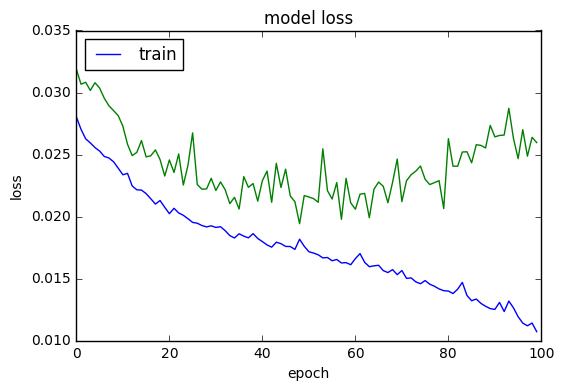

In [19]:
## Start Training
model.summary()
history_w_model = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=num_epochs, batch_size=64, validation_data=(x_valid, y_valid))

plt.plot(history_w_model.history['loss'], label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history_w_model.history['val_loss'], label='Val_loss')
plt.show()

In [20]:
''' (Optional) Save Model '''

# serialize model to JSON

# model_json = model.to_json()
# with open("model_V.M._3-0-p1.json", "w") as json_file:
#     json_file.write(model_json)

' (Optional) Save Model '

In [21]:
''' (Optional) Load the saved model '''

# load json and create model

# json_file = open('model_500x5_300e.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()

# loaded_model = model_from_json(loaded_model_json)

' (Optional) Load the saved model '

In [22]:
# Notes: last best model: 0.00175
# load weights into the model
model.load_weights("best_epoch_V.M._3-1_1d_val.hdf5")
print("Loaded model from disk")

model.compile(loss='mean_squared_error', optimizer='adam')

Loaded model from disk


In [24]:
''' === Prediction ===
Procedure:
1. Load CSV
2. to_datetime
3. create timeofday column
4. select the time for training: 6:00-8:00 (6 timestamps) and 15:00-17:00 (6 timestamps)
5. change it to stationary
6. Use using_cols to select the features
7. change to np array
8. MinMaxScaler
9. make the sequences tensor as input
10. make a forloop for prediction

'''
# 1. Load CSV - Vol + Route + Weather (Only Weather is 24-hour data)
df_pred = pd.read_csv('../data/preprocessed_input_interpolate_20min_phase2_test.csv')

# 2. to_datetime
df_pred['date'] = pd.to_datetime(df_pred['date'])

# 3. create timeofday column
df_pred['timeofday'] = df_pred.date.apply( lambda d : d.hour+d.minute/60.)

# Select the checking days (No need to real final test)

# start_day = datetime.datetime(year=2016, month=10, day=18, hour=1, minute=0, second=0)
# end_day = datetime.datetime(year=2016, month=10, day=24, hour=23, minute=0, second=0)

# df_pred_sel = df_pred[(df_pred['date'] > start_day) & (df_pred['date'] < end_day)]

df_pred_sel = df_pred

# 4. select the time for training

df_pred_sel_time = df_pred_sel[ ((df_pred_sel.timeofday>= 6) & (df_pred_sel.timeofday<8)) |
                            ((df_pred_sel.timeofday>=15) & (df_pred_sel.timeofday<17))]

df_feedin_weather_sel_time = df_pred_sel[ ((df_pred_sel.timeofday>= 8) & (df_pred_sel.timeofday<10)) |
                            ((df_pred_sel.timeofday>=17) & (df_pred_sel.timeofday<19))]

## 4.1 (For checking Phase1 Test_answer only)
# ''' For checking Answer'''
# df_check_answer = df_pred_sel[ ((df_pred_sel.timeofday>= 8) & (df_pred_sel.timeofday<10)) |
#                             ((df_pred_sel.timeofday>=17) & (df_pred_sel.timeofday<19))]

# df_check_answer = df_check_answer[using_cols]
# df_check_answer = df_check_answer["(3, 1, 'tot')"]
# check_ans_arr = df_check_answer.values

# check_ans_arr[0]

# Checking
df_pred_sel_time.iloc[12]

# 5. change it to stationary
df_pred_sel_time = df_pred_sel_time.reset_index(drop=True)

df_pred_sel_time_copy = df_pred_sel_time.copy()

for i in range(len(df_pred_sel_time_copy)//6):  # make the loop for 14 time slots (2 different time slot x 7days)
    for t in range(5):  #  Do the "difference" 5 times every loop
        start_idx = i*6 + t + 1  # Add 1 is for starting it from index 1 in every 6-space time slot
        df_pred_sel_time_copy.loc[start_idx, df_pred_sel_time_copy.columns[0:36]] = df_pred_sel_time.loc[start_idx, df_pred_sel_time.columns[0:36]] - df_pred_sel_time.loc[start_idx-1, df_pred_sel_time.columns[0:36]]

# Create one-hot for it
# for i in range(24):
#     df_pred_sel_time_copy['{}:00'.format(i)] = np.where(df_pred_sel_time_copy.hour == i, 1, 0)
#     df_feedin_weather_sel_time['{}:00'.format(i)] = np.where(df_feedin_weather_sel_time.hour == i, 1, 0)

# 6. Use using_cols to select the features

sel_rows_pred = df_pred_sel_time_copy[ using_cols ]

sel_rows_feedin_weather = df_feedin_weather_sel_time[using_cols[output_dim:]]

sel_rows_pred

# 7. change to np array
pred_arr = sel_rows_pred.values

feedin_weather_arr = sel_rows_feedin_weather.values

# 8. MinMaxScaler
pred_arr_scaled = scaler.transform(pred_arr)

# add some dummy cells in front of the weather_array for transform
temp_arr = np.zeros((84,output_dim))
feedin_weather_arr = np.concatenate([temp_arr, feedin_weather_arr], axis=1)

feedin_weather_arr_scaled = scaler.transform(feedin_weather_arr)

# Now pred_arr_scaled is (84 x features)

# 9. make the sequences tensor as input
# Put into the model to get the prediction

ans_arr = []  # For holding the output answer
    
for i in range(len(pred_arr_scaled)//6):  # make the loop for 14 time slots (2 different time slot x 7days)
    # creating pre_seq
    pred_seq = []
    for t in range(5):  #  Do the "difference" 5 times every loop
        k = i*6 + t + 1  # Add 1 is for starting it from index 1 in every 6-space time slot, to ignore the first index which is non-stationary
        pred_seq.append(pred_arr_scaled[k])  # creating a sequence for a time slot
    
    # creating feedin_weather_seq
    feedin_weather_seq = []
    for t in range(6):  #  Do 6 times every loop
        k = i*6 + t  #
        feedin_weather_seq.append(feedin_weather_arr_scaled[k])


    pred_seq = np.stack(pred_seq)  # change back to the numpy array (2D)
    pred_seq = pred_seq.reshape(1, pred_seq.shape[0], pred_seq.shape[1])  # change to numpy 3D as input

    feedin_weather_seq = np.stack(feedin_weather_seq)  # change back to the numpy array (2D)
    feedin_weather_seq = feedin_weather_seq.reshape(1, feedin_weather_seq.shape[0], feedin_weather_seq.shape[1])  # change to numpy 3D as input

    for q in range(6):
        # predict next timestamp
        output_pred = model.predict(pred_seq)  # get one prediction output (size (1 x output feature(s)))
        ans_arr.append(output_pred)

        # update the input seq
        for j in range(1,5):
            pred_seq[0][j-1] = pred_seq[0][j]
        pred_seq[0][4] = feedin_weather_seq[0][q]
        pred_seq[0][4][0:output_dim] = output_pred[0]

# 10. Backward to the non-stationary, correct scale output

#  Helper functions

def backward_scaler(nn_output):
    tmp = np.zeros(14)
    tmp[0:output_dim] = nn_output
    tmp = scaler.inverse_transform(tmp)
    return tmp[0:output_dim]

def decode(last_timestamp_values, nn_output):
    tmp = np.zeros(input_dim)
    tmp[0:output_dim] = nn_output
    tmp = scaler.inverse_transform(tmp)
    return last_timestamp_values + tmp[0:output_dim]

# create the non-stationary 6:40 and 16:40 for decoding
df_non_station_sel_time = df_pred_sel[ ((df_pred_sel.timeofday>= 7.5) & (df_pred_sel.timeofday<8)) |
                            ((df_pred_sel.timeofday>=16.5) & (df_pred_sel.timeofday<17))]

''' Output the non-stationary Answers (allAns)'''

tmp = df_non_station_sel_time[using_cols[0:output_dim]].values
allAns = []
for i in range(len(tmp)):
    seed = tmp[i]  # non-stationary for reconstructing a sequence
    segmentAns = []
    for timestep in range(6):
        seed = decode(seed, ans_arr[i*6+timestep])
        segmentAns.append(seed)
    allAns.append(segmentAns)

# Change back to np array for easy visualize
allAns = np.array(allAns)

# Checking
for i in allAns:
    print(i)

# 11. Output the CSV file

# create the datetime objects
import datetime

pred_start_date = 25


start_8am = datetime.datetime(year=2016, month=10, day=pred_start_date, hour=8, minute=0, second=0)
start_5pm = datetime.datetime(year=2016, month=10, day=pred_start_date, hour=17, minute=0, second=0)
add_1_day = datetime.timedelta(days=1)
add_20_min = datetime.timedelta(minutes=20)

'''
allAns[x,y,z]
[x]: Segment (AM & PM, total 14)
[y]: timestamp (6 [20mins])
[z]: 3 features
'''
# allAns[0,:,1]

[[ 154.33380662   35.61934064  104.13441738]
 [ 147.29572757   44.07640857  115.8023454 ]
 [ 148.32734458   43.33726378  114.4061626 ]
 [ 141.58706593   35.46771543  109.7152272 ]
 [ 129.6097195    35.27628256  110.4512417 ]
 [ 132.8122826    31.93706329  103.66384258]]
[[ 120.06070377   27.15563984   92.29376478]
 [ 117.92016392   28.26188939   92.72982955]
 [ 109.66499453   27.74581923   90.87447556]
 [ 107.35916998   28.15899509   90.92487992]
 [ 107.96224734   28.53278751   90.06787154]
 [ 103.18687765   28.66447133   87.52439975]]
[[ 147.9569894    33.08819807  101.97681556]
 [ 152.06568065   40.13663726  116.38252363]
 [ 152.81888347   45.17486557  120.41711118]
 [ 153.20462524   35.27261042  110.85351001]
 [ 139.43310678   38.27004497  114.56140663]
 [ 144.87395802   33.81647931  106.71234801]]
[[ 122.71351434   27.70966107  101.99655761]
 [ 117.74647512   30.16045583  102.70763285]
 [ 111.79506781   29.08016242   96.95025852]
 [ 110.40384883   28.73770662   93.45008904]
 [ 108.

/Users/Kin/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Kin/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Kin/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data h

'\nallAns[x,y,z]\n[x]: Segment (AM & PM, total 14)\n[y]: timestamp (6 ins])\n[z]: 3 features\n'

In [25]:
# 11.a [FOR TRAFFIC TIME] Output the CSV file

# route = 'A'
# checkpoint = '2'
# vol_or_traj = 0  # select the output cell

# with open('{}-{}_checking_A-2_single.csv'.format(route, checkpoint), 'w') as f:
#     for day in range(7):
#         for am_pm in range(2):
#             if am_pm == 0:
#                 ref_time = start_8am
#             else:
#                 ref_time = start_5pm
#             for timestep in range(6):
#                 start_timestamp = ref_time + day*add_1_day + timestep*add_20_min
#                 end_timestamp = start_timestamp + add_20_min
#                 start_timestr = start_timestamp.strftime("%Y-%m-%d %H:%M:00")
#                 end_timestr = end_timestamp.strftime("%Y-%m-%d %H:%M:00")
#                 f.write('{},{},"[{},{})",{}\n'.format(route,
#                                                       checkpoint,
#                                                       start_timestr,
#                                                       end_timestr,
#                                                       allAns[day*2+am_pm, timestep, vol_or_traj ]))

In [26]:
allAns

array([[[ 154.33380662,   35.61934064,  104.13441738],
        [ 147.29572757,   44.07640857,  115.8023454 ],
        [ 148.32734458,   43.33726378,  114.4061626 ],
        [ 141.58706593,   35.46771543,  109.7152272 ],
        [ 129.6097195 ,   35.27628256,  110.4512417 ],
        [ 132.8122826 ,   31.93706329,  103.66384258]],

       [[ 120.06070377,   27.15563984,   92.29376478],
        [ 117.92016392,   28.26188939,   92.72982955],
        [ 109.66499453,   27.74581923,   90.87447556],
        [ 107.35916998,   28.15899509,   90.92487992],
        [ 107.96224734,   28.53278751,   90.06787154],
        [ 103.18687765,   28.66447133,   87.52439975]],

       [[ 147.9569894 ,   33.08819807,  101.97681556],
        [ 152.06568065,   40.13663726,  116.38252363],
        [ 152.81888347,   45.17486557,  120.41711118],
        [ 153.20462524,   35.27261042,  110.85351001],
        [ 139.43310678,   38.27004497,  114.56140663],
        [ 144.87395802,   33.81647931,  106.71234801]],

    

In [27]:
# 11.b [FOR VOLUME] Output the CSV file

checkpoint = '3'
direction = '1'
vol_or_traj = 2  # select the output cell

with open('_final_{}-{}_1d_val.csv'.format(checkpoint, direction), 'w') as f:
    for day in range(7):
        for am_pm in range(2):
            if am_pm == 0:
                ref_time = start_8am
            else:
                ref_time = start_5pm
            for timestep in range(6):
                start_timestamp = ref_time + day*add_1_day + timestep*add_20_min
                end_timestamp = start_timestamp + add_20_min
                start_timestr = start_timestamp.strftime("%Y-%m-%d %H:%M:00")
                end_timestr = end_timestamp.strftime("%Y-%m-%d %H:%M:00")
                f.write('{},"[{},{})",{},{}\n'.format(checkpoint,
                                                  start_timestr,
                                                  end_timestr,
                                                  direction,
                                                  allAns[day*2+am_pm, timestep, vol_or_traj ]))